IMPORTS, LOADING, AND PREPROCESSING

In [26]:
# import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [27]:
# check PyTorch and GPU setup
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch Version: 2.5.1+cu124
CUDA Available: True
GPU Name: NVIDIA L4


In [28]:
# preprocessing transformation
# convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor(),
                                ])

In [29]:
# load cifar-10 dataset
# partition into train and test sets
trainset=torchvision.datasets.CIFAR10(
    root='./data',
    train=True, # load training set (50k images)
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False, # load test set (10k images)
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
# create dataloaders
train_loader = DataLoader(trainset, batch_size=6, shuffle=True)
test_loader = DataLoader(testset, batch_size=6, shuffle=False)

In [31]:
# inspect data
dataiter = iter(train_loader) # iterator to grab batch
images, labels = next(dataiter) # get first batch
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)
print("Image value range:", images.min().item(), "to", images.max().item())

Batch of images shape: torch.Size([6, 3, 32, 32])
Batch of labels shape: torch.Size([6])
Image value range: 0.0235294122248888 to 1.0


In [32]:
# define class names for reference
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


print("Class names:", class_names)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


VERIFY AND VISUALIZE DATA

In [33]:
# check full dataset range
all_images = torch.stack([img for img, _ in trainset]) # stacks all 50k training images
print("Full training set value range:", all_images.min().item(), "to", all_images.max().item())

Full training set value range: 0.0 to 1.0


In [34]:
# function to visualize images
def show_images(images, labels, class_names, num_images=4):
  plt.figure(figsize=(10,3))
  for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    # permute tensor from [3, 32, 32] to [32, 32, 3] for display
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis('off')
  plt.show()

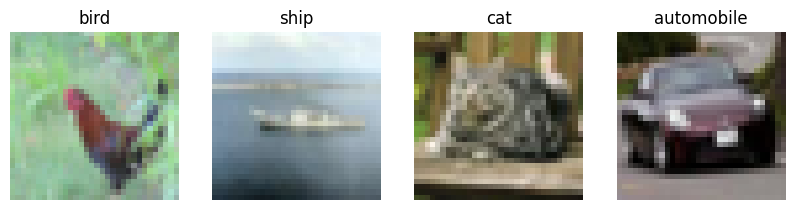

In [35]:
# grab a batch and visualize
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images, labels, class_names, num_images=4)

GENERATING PAIRS FOR SIAMESE NETWORK

In [36]:
# import dataset class
from torch.utils.data import Dataset

# define custom siamese dataset class
class SiameseCIFAR10Dataset(Dataset):
  def __init__(self, dataset, num_pairs_per_class=200):
    self.dataset = dataset # cifar-10 dataset
    self.num_pairs_per_class = num_pairs_per_class
    self.num_classes = 10
    # unzip images and labels from dataset
    self.images, self.labels = zip(*[(img, lbl) for img, lbl in dataset])
    self.labels = torch.tensor(self.labels) # convert labels to tensor
    self.pairs, self.pair_labels = self._generate_pairs() # create pairs

  def _generate_pairs(self):
    pairs = []
    pair_labels = []
    import numpy as np # for random sampling

    # generate positive pairs (same class)
    for class_idx in range(self.num_classes):
      # find indices of images in class
      class_indices = (self.labels == class_idx).nonzero(as_tuple=True)[0]
      # check if enough images for pairs
      if len(class_indices) < 2:
        continue
      # generate pairs
      for _ in range(self.num_pairs_per_class):
        idx1, idx2 = np.random.choice(class_indices, 2, replace=False)
        pairs.append([self.images[idx1], self.images[idx2]])
        pair_labels.append(1)

    # generate negative pairs (diff. class)
    for _ in range(self.num_pairs_per_class * self.num_classes):
      # pick 2 different classes
      class1, class2 = np.random.choice(self.num_classes, 2, replace=False)
      idx1= np.random.choice((self.labels == class1).nonzero(as_tuple=True)[0])
      idx2 = np.random.choice((self.labels == class2).nonzero(as_tuple=True)[0])
      pairs.append([self.images[idx1], self.images[idx2]])
      pair_labels.append(0)

    return pairs, torch.tensor(pair_labels, dtype=torch.float32)

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, idx):
    img1, img2 = self.pairs[idx] # get the 2 images
    label = self.pair_labels[idx] # get label
    return img1, img2, label


In [37]:
# create Siamese dataset
siamese_trainset = SiameseCIFAR10Dataset(trainset, num_pairs_per_class=200)

# batch the pairs w/ DataLoader
train_loader = DataLoader(siamese_trainset, batch_size=4, shuffle=True)

In [38]:
# check a batch
dataiter = iter(train_loader)
img1, img2, labels = next(dataiter)
print("Image 1 batch shape:", img1.shape)
print("Image 2 batch shape:", img2.shape)
print("Labels shape:", labels.shape)
print("Total pairs:", len(siamese_trainset))

Image 1 batch shape: torch.Size([4, 3, 32, 32])
Image 2 batch shape: torch.Size([4, 3, 32, 32])
Labels shape: torch.Size([4])
Total pairs: 4000


VISUALIZE PAIRS

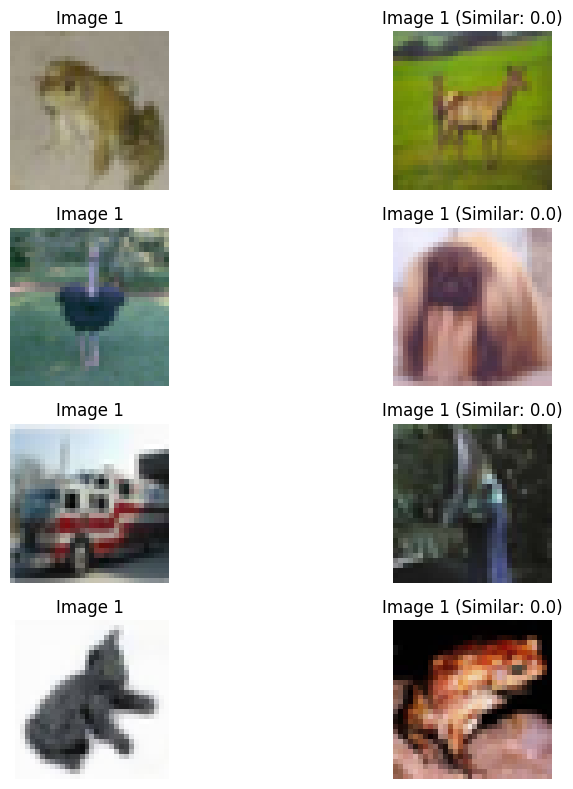

In [39]:
# function to plot Siamese pairs
def show_pairs(img1, img2, labels, class_names, num_pairs=4):
  plt.figure(figsize=(10, 2 * num_pairs)) # widdth 10, height scales w/ pairs
  for i in range(num_pairs):
    # plot first image in pair
    plt.subplot(num_pairs, 2, 2* i + 1) # num_pairs rows, 2 columns
    plt.imshow(img1[i].permute(1, 2, 0).numpy())
    plt.title("Image 1")
    plt.axis('off')

    # second image in pair
    plt.subplot(num_pairs, 2, 2* i + 2) # num_pairs rows, 2 columns
    plt.imshow(img2[i].permute(1, 2, 0).numpy())
    plt.title(f"Image 1 (Similar: {labels[i].item()})")
    plt.axis('off')

  plt.tight_layout() # adjust spacing
  plt.show()

# get a batch from train_loader
dataiter = iter(train_loader)
img1, img2, labels = next(dataiter)

# visualize 4 pairs
show_pairs(img1, img2, labels, class_names, num_pairs=4)


DEFINE SIAMESE NEURAL NETWORK MODEL

In [40]:
# import torch.nn.functional for activation function
import torch.nn.functional as F

# base CNN architecture
class BaseCNN(nn.Module):
  def __init__(self):
    super(BaseCNN, self).__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding=1) # input: 3 channels (rbg), output: 32 channels
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # input: 32, output: 64
    # pooling layer
    self.pool = nn.MaxPool2d(2, 2) # reduces size by half
    # full connected layer
    self.fc1 = nn.Linear(64*8*8, 128) # after pooling twice: 32x32 to 16x16 to 8x8

  def forward(self, x):
    # input x [batch_size, 3, 32, 32]
    x = F.relu(self.conv1(x)) # apply conv1 and ReLU
    x = self.pool(x) # pool: 32x32 to 16x16
    x = F.relu(self.conv2(x)) # apply conv2 and ReLU
    x = self.pool(x) # pool: 16x16 to 8x8
    x = x.view(-1, 64 * 8 * 8) # flatten: [batch_size, 64 * 8 * 8]
    x = F.relu(self.fc1(x)) # fully connected layer to 128 features
    return x # [batch_size, 128]

# define Siamese Network
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.base_cnn = BaseCNN() # shared CNN for both images
    self.fc2 = nn.Linear(128, 1) # final layer to predict similarity


  def forward(self, img1, img2):
    # process both images through same CNN
    embedding1 = self.base_cnn(img1) # [batch_size, 128]
    embedding2 = self.base_cnn(img2) # [batch_size, 128]
    # compute absolute difference between embeddings
    distance = torch.abs(embedding1 - embedding2) # [batch_size, 128]
    # predict similarity
    output = torch.sigmoid(self.fc2(distance)) # [batch_size, 1]
    return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
print("Model moved to:", device)

# test with batch
img1, img2, labels = next(iter(train_loader))
img1, img2 = img1.to(device), img2.to(device) # move to GPU
output = model(img1, img2)
print("Output shape:", output.shape)
print("Sample output:", output[:2])

Model moved to: cuda
Output shape: torch.Size([4, 1])
Sample output: tensor([[0.4882],
        [0.4899]], device='cuda:0', grad_fn=<SliceBackward0>)


TRAINING MODEL

In [41]:
import torch.optim as optim

# define loss function & optimizer
criterion = nn.BCELoss() # binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training function
def train_model(mode, train_loader, criterion, optimizer, num_epochs=5):
  model.train()
  for epoch in range(num_epochs):
    running_loss = 0.0
    for img1, img2, labels in train_loader:
      # move data to GPU
      img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

      # zero gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(img1, img2) # [batch_size, 1]
      loss = criterion(outputs.squeeze(), labels)

      # backward pass & optimize
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * img1.size(0) # total loss for batch

    # average loss for the epoch
    epoch_loss = running_loss/len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


# train model
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch [1/15], Loss: 0.6932
Epoch [2/15], Loss: 0.6818
Epoch [3/15], Loss: 0.6583
Epoch [4/15], Loss: 0.6341
Epoch [5/15], Loss: 0.6058
Epoch [6/15], Loss: 0.5628
Epoch [7/15], Loss: 0.5119
Epoch [8/15], Loss: 0.4486
Epoch [9/15], Loss: 0.3805
Epoch [10/15], Loss: 0.3096
Epoch [11/15], Loss: 0.2269
Epoch [12/15], Loss: 0.1697
Epoch [13/15], Loss: 0.1139
Epoch [14/15], Loss: 0.1007
Epoch [15/15], Loss: 0.0687


TEST DIFFERENT EPOCHS AND BATCH SIZES

Running on: cuda
Files already downloaded and verified

Testing: Epochs=5, Batch Size=4
Epoch [1/5], Loss: 0.6904
Epoch [2/5], Loss: 0.6795
Epoch [3/5], Loss: 0.6666
Epoch [4/5], Loss: 0.6495
Epoch [5/5], Loss: 0.6251
Final Loss: 0.6251

Testing: Epochs=5, Batch Size=8
Epoch [1/5], Loss: 0.6877
Epoch [2/5], Loss: 0.6734
Epoch [3/5], Loss: 0.6507
Epoch [4/5], Loss: 0.6221
Epoch [5/5], Loss: 0.5857
Final Loss: 0.5857

Testing: Epochs=5, Batch Size=16
Epoch [1/5], Loss: 0.6926
Epoch [2/5], Loss: 0.6866
Epoch [3/5], Loss: 0.6717
Epoch [4/5], Loss: 0.6518
Epoch [5/5], Loss: 0.6338
Final Loss: 0.6338

Testing: Epochs=10, Batch Size=4
Epoch [1/10], Loss: 0.6813
Epoch [2/10], Loss: 0.6599
Epoch [3/10], Loss: 0.6426
Epoch [4/10], Loss: 0.6197
Epoch [5/10], Loss: 0.5943
Epoch [6/10], Loss: 0.5616
Epoch [7/10], Loss: 0.5210
Epoch [8/10], Loss: 0.4719
Epoch [9/10], Loss: 0.4101
Epoch [10/10], Loss: 0.3453
Final Loss: 0.3453

Testing: Epochs=10, Batch Size=8
Epoch [1/10], Loss: 0.6851
Epoch [2/10],

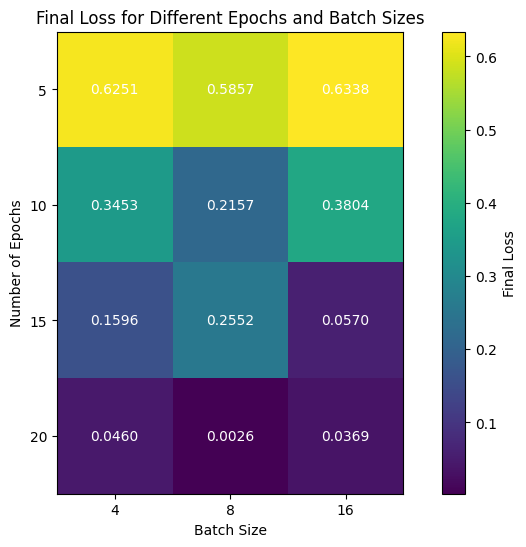

In [43]:
import numpy as np

# function to test different epochs and batch sizes
def test_hyperparameters(epoch_options, batch_size_options, num_pairs_per_class=200):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on: {device}")

    # preprocessing transformation
    transform = transforms.Compose([transforms.ToTensor()])

    # load CIFAR-10 training dataset
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )

    results = []

    # iterate over all combinations
    for num_epochs in epoch_options:
        for batch_size in batch_size_options:
            print(f"\nTesting: Epochs={num_epochs}, Batch Size={batch_size}")

            # create Siamese dataset and loader
            siamese_trainset = SiameseCIFAR10Dataset(trainset, num_pairs_per_class=num_pairs_per_class)
            train_loader = DataLoader(siamese_trainset, batch_size=batch_size, shuffle=True)

            # initialize fresh model
            model = SiameseNetwork().to(device)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            # train the model
            model.train()
            for epoch in range(num_epochs):
                running_loss = 0.0
                for img1, img2, labels in train_loader:
                    img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(img1, img2)
                    loss = criterion(outputs.squeeze(), labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * img1.size(0)

                epoch_loss = running_loss / len(siamese_trainset)
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

            # final loss
            final_loss = epoch_loss
            results.append({
                'epochs': num_epochs,
                'batch_size': batch_size,
                'final_loss': final_loss
            })
            print(f"Final Loss: {final_loss:.4f}")

    # display text summary
    print("\nSummary of Results:")
    for result in results:
        print(f"Epochs: {result['epochs']}, Batch Size: {result['batch_size']}, Final Loss: {result['final_loss']:.4f}")

    best_result = min(results, key=lambda x: x['final_loss'])
    print(f"\nBest Combination: Epochs={best_result['epochs']}, Batch Size={best_result['batch_size']}, Final Loss={best_result['final_loss']:.4f}")

    # visualize results
    visualize_results(results, epoch_options, batch_size_options)

    return results

# function to visualize the results as heatmap
def visualize_results(results, epoch_options, batch_size_options):
    # converts results to a 2d array for plotting
    loss_matrix = np.zeros((len(epoch_options), len(batch_size_options)))
    for result in results:
        i = epoch_options.index(result['epochs'])
        j = batch_size_options.index(result['batch_size'])
        loss_matrix[i, j] = result['final_loss']

    # create heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(loss_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Final Loss')
    plt.xticks(np.arange(len(batch_size_options)), batch_size_options)
    plt.yticks(np.arange(len(epoch_options)), epoch_options)
    plt.xlabel('Batch Size')
    plt.ylabel('Number of Epochs')
    plt.title('Final Loss for Different Epochs and Batch Sizes')

    # text annotations for each cell
    for i in range(len(epoch_options)):
        for j in range(len(batch_size_options)):
            plt.text(j, i, f"{loss_matrix[i, j]:.4f}", ha='center', va='center', color='white')

    plt.show()

# test usage
epoch_options = [5, 10, 15, 20]
batch_size_options = [4, 8, 16]
results = test_hyperparameters(epoch_options, batch_size_options, num_pairs_per_class=200)